In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *
from utils.detectron2helper import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



HACKING: overriding COCOeval.summarize = vin_summarize...


In [3]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [4]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "detectron2_results/cascade_mask_rcnn_R_50_FPN_3x_mkf_5_1024_rm"
    device: str = "cuda:1"
    device_id: int = 1
    num_workers: int = 8

    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    test_meta_file: str = '../../data/VinBigData/test_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png1024"
    img_size: int = 1024
    seed: int = 111
    n_splits: int = 5
    iou_thr: float = 0.5
    skip_box_thr: float = 0.0001
    rm: bool = False
    
    model_config: str = 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'
#     mkf: bool = True
    
    # Training config
    batch_size: int = 2
    iter: int = 10000
    lr_scheduler_name: str = "WarmupCosineLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    checkpoint_period: int = 10000
        
    aug_kwargs: Dict = field(default_factory=lambda: {})
        

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [5]:
config_dict = {
    'debug': False,
    'batch_size': 2,
    'base_lr': 1e-4,
    'iou_thr': 0.5,
    'rm': True,
    'iter': 10000,
    'eval_period': 1000,
    'checkpoint_period': 1000,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
    },
}
config = Config().update(config_dict)

In [6]:
base_dir = Path().resolve()


classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [7]:
def read_metrics(filepath: Path):
    metrics_df = pd.read_json(filepath, orient="records", lines=True)
    mdf = metrics_df.sort_values("iteration")
    return mdf


def plot(mdf: pd.DataFrame, classes_nms: List[str]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # loss
    mdf1 = mdf[~mdf["total_loss"].isna()]
    axes[0].plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
    if "validation_loss" in mdf.columns:
        mdf2 = mdf[~mdf["validation_loss"].isna()]
        axes[0].plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
    axes[0].legend()
    axes[0].set_title("Loss curve")
    
    # AP
    mdf3 = mdf[~mdf["bbox/AP75"].isna()]
    axes[1].plot(mdf3["iteration"], mdf3["bbox/AP75"] / 100., c="C2", label="validation")

    axes[1].legend()
    axes[1].set_title("AP40")
    
    # AP by class
    mdf_bbox_class = mdf3.iloc[-1][[f"bbox/AP-{col}" for col in classes_nms]]
    mdf_bbox_class.plot(kind="bar", ax=axes[2])
    _ = axes[2].set_title("AP by class")
    
    plt.show()

In [8]:
# mdf = read_metrics(base_dir / f'detectron2_results/results01/fold-1/metrics.json')
# plot(mdf, classes_nms=[
#     "Aortic enlargement",
#     "Atelectasis",
#     "Calcification",
#     "Cardiomegaly",
#     "Consolidation",
#     "ILD",
#     "Infiltration",
#     "Lung Opacity",
#     "Nodule/Mass",
#     "Other lesion",
#     "Pleural effusion",
#     "Pleural thickening",
#     "Pneumothorax",
#     "Pulmonary fibrosis",
# #     "No Finding"
# ])

In [9]:
# mdf = read_metrics(base_dir / f'detectron2_results/retinanet_R_101_FPN_3x_mkf_5_256/fold-1/metrics.json')
# plot(mdf, classes_nms=[
# #     "Aortic enlargement",
#     "Atelectasis",
#     "Calcification",
# #     "Cardiomegaly",
#     "Consolidation",
#     "ILD",
#     "Infiltration",
#     "Lung Opacity",
#     "Nodule/Mass",
#     "Other lesion",
#     "Pleural effusion",
#     "Pleural thickening",
#     "Pneumothorax",
#     "Pulmonary fibrosis",
# #     "No Finding"
# ])

## Validation

In [10]:
def load_train_data(filepath: str, meta_filepath: str, img_size: int) -> pd.DataFrame:
    train = pd.read_csv(filepath)
    train.fillna(0, inplace=True)
    train.loc[train["class_id"] == 14, ['x_max', 'y_max']] = 1.0
    
    train_meta = pd.read_csv(meta_filepath)
    
    train = pd.merge(train, train_meta, how='left', on='image_id')
    
    train[f'x_min_{img_size}'] = (img_size / train['dim1'] * train['x_min'])
    train[f'x_max_{img_size}'] = (img_size / train['dim1'] * train['x_max'])
    train[f'y_min_{img_size}'] = (img_size / train['dim0'] * train['y_min'])
    train[f'y_max_{img_size}'] = (img_size / train['dim0'] * train['y_max'])
    
    return train


from ensemble_boxes import *


def change_wbf(dataset_dict: Dict[str, Any], iou_thr: float, skip_box_thr: float, n_cls: int):
    cls_ids = list(range(n_cls))
    
    height, width = dataset_dict['height'], dataset_dict['width']
    
    boxes = list()
    labels = list()
    scores = [1.0] * len(dataset_dict['annotations'])
        
    for obj in dataset_dict['annotations']:
        box = [
            obj['bbox'][0] / width,
            obj['bbox'][1] / height,
            obj['bbox'][2] / width,
            obj['bbox'][3] / height
        ]
        boxes += [box]
        labels += [obj['category_id']]
    
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    annots = list()
    for box_, label_ in zip(boxes, labels):
        annots += [{
            'bbox': [
                box_[0] * width,
                box_[1] * height,
                box_[2] * width,
                box_[3] * height
            ],
            'category_id': int(label_),
            'bbox_mode': BoxMode.XYXY_ABS,
        }]
        
    return {
        'file_name': dataset_dict['file_name'],
        'image_id': dataset_dict['image_id'],
        'height': height,
        'width': width,
        'annotations': annots
    }

In [11]:
from typing import List, Tuple

import matplotlib.patches as patches
import numpy as np
from PIL import Image


def add_bboxes_to_image(ax, image: np.ndarray,
                        bboxes: List[Tuple[int, int, int, int]],
                        labels: List[str] = None,
                        label_size: int = 10,
                        line_width: int = 2,
                        border_color=(0, 1, 0, 1)) -> None:
    """
    Add bbox to ax

    :param image: dtype=np.uint8
    :param bbox: [(left, top, right, bottom)]
    :param label: List[str] or None
    :return: ax
    """
    # Display the image
    ax.imshow(image)

    if labels is None:
        labels = [None] * len(bboxes)

    for bbox, label in zip(bboxes, labels):
        # Add bounding box
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=line_width,
                                 edgecolor=border_color,
                                 facecolor='none')
        ax.add_patch(rect)

        bbox_props = dict(boxstyle="square,pad=0",
                          linewidth=line_width, facecolor=border_color,
                          edgecolor=border_color)
        ax.text(x_min, y_min, label,
                    ha="left", va="bottom", rotation=0,
                    size=label_size, bbox=bbox_props)
    return ax

In [12]:
import argparse
import dataclasses
import json
from dataclasses import dataclass
from distutils.util import strtobool
import cv2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data.samplers.distributed_sampler import RepeatFactorTrainingSampler

setup_logger()

<Logger detectron2 (DEBUG)>

In [13]:
rm = '_rm' if config.rm else ''
train = pickle.load(open(str(base_dir / f'nms{config.iou_thr}_train_{config.img_size}{rm}.pkl'), 'rb'))
dataset_dicts = pickle.load(open(str(base_dir / f'nms{config.iou_thr}_dataset_dicts_{config.img_size}{rm}.pkl'), 'rb'))
mkf = pickle.load(open(str(base_dir / f'nms{config.iou_thr}_mkf_{config.img_size}{rm}.pkl'), 'rb'))

In [14]:
from detectron2.config.config import CfgNode as CN

torch.cuda.set_device(config.device_id)

pred_df_list = list()

for fold, (_, valid_df) in enumerate(mkf):
    seed_everything(seed=config.seed, device=config.device)
    
    valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {valid_df['image_id'].values.tolist()}").index)
    dataset_dicts_valid = [dataset_dicts[i] for i in valid_idx]

    outdir = base_dir / config.outdir / f'fold-{fold + 1}'

    cfg = get_cfg()
    cfg.aug_kwargs = CN(config.aug_kwargs)  # pass aug_kwargs to cfg

    original_output_dir = cfg.OUTPUT_DIR
    cfg.OUTPUT_DIR = str(outdir)
    print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

    config_name = config.model_config
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.DATASETS.TRAIN = (f"vinbigdata_train_fold{fold + 1}",)
    cfg.DATASETS.TEST = (f"vinbigdata_valid_fold{fold + 1}",)
    cfg.TEST.EVAL_PERIOD = config.eval_period

    cfg.DATALOADER.NUM_WORKERS = config.num_workers

    cfg.MODEL.WEIGHTS = str(outdir /"model_final.pth")
    cfg.SOLVER.IMS_PER_BATCH = config.batch_size
    cfg.SOLVER.LR_SCHEDULER_NAME = config.lr_scheduler_name
    cfg.SOLVER.BASE_LR = config.base_lr  # pick a good LR
    cfg.SOLVER.MAX_ITER = config.iter
    cfg.SOLVER.CHECKPOINT_PERIOD = config.checkpoint_period  # Small value=Frequent save need a lot of storage.
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config.roi_batch_size_per_image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes_nms)
    
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16], [32], [64], [128], [256], [512], [1024]]
    cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p2', 'p3', 'p4', 'p5', 'p6', 'p6']
    cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.33, 0.5, 1.0, 2.0, 3.0]]

    print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0. # set a custom testing threshold
    print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
    predictor = DefaultPredictor(cfg)
    
    
    records = {'image_id': list(), 'PredictionString': list()}

    for i in tqdm(range(ceil(len(dataset_dicts_valid) / config.batch_size))):
        inds = list(range(config.batch_size * i, min(config.batch_size * (i + 1), len(dataset_dicts_valid))))
        dataset_dicts_test_batch = [dataset_dicts_valid[i] for i in inds]
        im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_test_batch]
        outputs_list = predict_batch(predictor, im_list)

        for outputs, dd in zip(outputs_list, dataset_dicts_test_batch):
            instances = outputs["instances"]
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"].cpu().numpy()
            pred_scores = fields["scores"].cpu().numpy()
            pred_boxes = fields["pred_boxes"].tensor.cpu().numpy()

            records['image_id'] += [dd['image_id']]
            records['PredictionString'] += [format_pred(pred_classes, pred_boxes, pred_scores)]

    pred_df_list += [pd.DataFrame(records)]
    
    del cfg, predictor
    gc.collect()

cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/cascade_mask_rcnn_R_50_FPN_3x_mkf_5_1024_rm/fold-1
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/450 [00:00<?, ?it/s]

cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/cascade_mask_rcnn_R_50_FPN_3x_mkf_5_1024_rm/fold-2
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/430 [00:00<?, ?it/s]

cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/cascade_mask_rcnn_R_50_FPN_3x_mkf_5_1024_rm/fold-3
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/440 [00:00<?, ?it/s]

cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/cascade_mask_rcnn_R_50_FPN_3x_mkf_5_1024_rm/fold-4
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/429 [00:00<?, ?it/s]

cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/cascade_mask_rcnn_R_50_FPN_3x_mkf_5_1024_rm/fold-5
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/442 [00:00<?, ?it/s]

In [15]:
# save predictions, which isn't post processed
for fold, pred_df in enumerate(pred_df_list):
    pred_df.to_csv(str(base_dir / config.outdir / f'fold-{fold + 1}' / 'validation.csv'), index=False)

In [ ]:
valid_evaluator = VinBigDataEval(train.query(f"image_id in {[dd['image_id'] for dd in dataset_dicts_valid]}"))

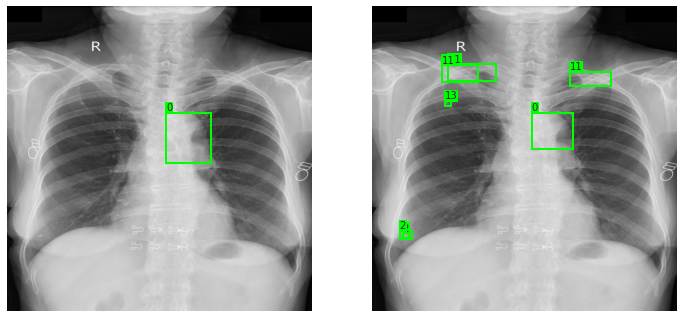

In [122]:
valid_dataset = VinBigDataset(dataset_dicts=dataset_dicts_valid, transform=Transform({}, train=True))
i = 147

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

img, target, image_id = valid_dataset[i]
img = img.numpy().transpose((1, 2, 0))
add_bboxes_to_image(axes[0], np.uint8(img), target['boxes'], target['labels'].numpy())
axes[0].axis("off")

pred = np.array(pred_valid_df.loc[i, 'PredictionString'].split(' ')).reshape(-1, 6)

boxes = pred[:, 2:].astype(float)
labels = pred[:, 0].astype(int)
scores = pred[:, 1].astype(float)

mask = (scores > 0.2)

add_bboxes_to_image(axes[1], np.uint8(img), boxes[mask, :], labels[mask])
axes[1].axis("off")

plt.show()

In [ ]:
def remove_lowscore(pred_df: pd.DataFrame, threshes: List[float]):
    assert len(classes_nms) == len(threshes)
    pred_df_ = pred_df.copy()
    
    for i in pred_df_.index:
        pred_str = list()
        for obj in np.array(pred_df_.loc[i, 'PredictionString'].split(' ')).reshape(-1, 6):
            try:
                thresh = threshes[int(obj[0])]
            except IndexError as e:
                continue
            
            if float(obj[1]) > thresh:
                pred_str += obj.tolist()
                
        pred_df_.loc[i, 'PredictionString'] = ' '.join(pred_str)
    
    return pred_df_


def evaluate_mAP(valid_pred_df: pd.DataFrame):
    mAPs = dict()
    for cls_id, cls_nm in tqdm(classes_dict.items()):
        results = valid_evaluator.evaluate(valid_pred_df, category_ids=[cls_id])
        mAPs[cls_nm] = results.stats[0]

    results = valid_evaluator.evaluate(valid_pred_df)
    mAPs['all'] = results.stats[0]
    
    return mAPs

In [105]:
mAPs = evaluate_mAP(pred_valid_df)

  0%|          | 0/14 [00:00<?, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.931
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.931
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.930
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.994
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.994
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

In [109]:
threshes = [0.25] * len(classes_nms)

mAPs_rm = evaluate_mAP(remove_lowscore(pred_valid_df, threshes))

  0%|          | 0/14 [00:00<?, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.919
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.979
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.979
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.979
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

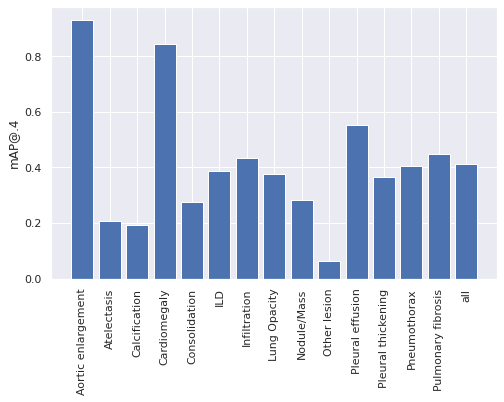

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(mAPs.keys(), mAPs.values())
ax.set_ylabel('mAP@.4')
plt.xticks(rotation=90)
plt.show()

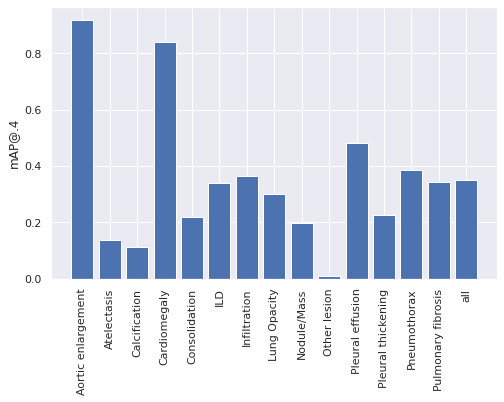

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(mAPs.keys(), mAPs_rm.values())
ax.set_ylabel('mAP@.4')
plt.xticks(rotation=90)
plt.show()